## 라이브러리 및 chunk json 호출

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='NanumGothic') 
plt.rcParams['axes.unicode_minus'] = False 
from matplotlib import font_manager
# 폰트 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  
font_prop = font_manager.FontProperties(fname=font_path)
import json
from konlpy.tag import Okt
from collections import Counter
import itertools


In [2]:
import json
import pandas as pd

# 차종 리스트
cars = ['avante', 'casper', 'grandeur', 'ionic5',
        'santafe', 'sonata', 'staria', 'tucson']

for car in cars:
    file_path = f"../chunker/{car}_Owner's_Manual_pdfminer_chunks.json"
    data = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))

    # 차종 이름을 변수 이름으로 저장
    globals()[car] = pd.DataFrame(data)



In [6]:
print(casper['text'].iloc[167])
print(santafe['text'].iloc[409])
print(sonata['text'].iloc[300])
print(tucson['text'].iloc[303])
print(tucson['text'].iloc[310])

전방 충돌방지 보조 (FCA)(전
전방 충돌방지 보조 (FCA)
전방 충돌방지 보조 (FCA) (센
전방 충돌방지 보조 (FCA) (전
전방 충돌방지 보조 (FCA) (센


tf-idf를 구하기 위해, 형태소 분석기를 이용해서
불용어 제거 및 차종별로 토큰 저장

In [17]:
from konlpy.tag import Okt

# 형태소 분석기 초기화
okt = Okt()

# 차종 리스트
car = ['avante', 'casper', 'grandeur', 'ionic5',
       'santafe', 'sonata', 'staria', 'tucson']

# 불용어 리스트
stopwords = ['수', '를', '고', '이', '경', '주', '중', '시오', '의', '후', '시', '수',
             '등', '때', '및', '경우', '로']

# 차종별 처리
for car_name in car:
    df = globals()[car_name]  # 예: avante
    texts = df['text'].tolist()

    tokenized = [okt.nouns(text) for text in texts]  # 명사 추출

    filtered_tokens = [
        [word for word in sentence if word not in stopwords] for sentence in tokenized
    ]

    # 변수명 동적으로 생성
    globals()[f"{car_name}_filtered_tokens"] = filtered_tokens



차종 별 tf-idf 상위 50개 단어 저장
* tf-idf:문서에서 특정 단어가 자주 등장하지만 전체 문서에서는 드물게 등장할수록 더 중요한 단어로 간주하는 가중치 계산 방법

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

cars = ['avante', 'casper', 'grandeur', 'ionic5',
        'santafe', 'sonata', 'staria', 'tucson']

for car in cars:
    # ex) avante_filtered_tokens
    token_list = globals()[f"{car}_filtered_tokens"]
    
    # 문서별로 띄어쓰기 기준 연결
    docs = [' '.join(tokens) for tokens in token_list]
    
    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(docs)
    
    # 단어와 점수 추출
    words = vectorizer.get_feature_names_out()
    scores = X.sum(axis=0).A1
    word_scores = dict(zip(words, scores))
    
    # 각 차종별로 '차종_word_scores' 변수로 저장
    globals()[f"{car}_word_scores"] = word_scores
    
    # 상위 50개 단어 추출
    top_50 = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:50]
    
    # ex) avante_top_50 이라는 변수로 저장
    globals()[f"{car}_top_50"] = top_50



## 공통 분모 찾기

차종별 tf-idf를 이용해, 모든 차종에서 나온 단어, 6~7(대부분의 차종에서 나온 단어),
3~5(모든 차종에서 나오는 것은 아니나 중복되는 단어)로 분류

In [30]:
import itertools
from collections import Counter

cars = ['avante', 'casper', 'grandeur', 'ionic5', 'santafe', 'sonata', 'staria', 'tucson']

# 1. 각 차종 top 50 단어를 set으로 저장
car_top_word_sets = {
    car: set([word for word, score in globals()[f"{car}_top_50"]])
    for car in cars
}

# 2. 모든 단어를 한 리스트로 합치고, 등장 횟수 세기
all_top_words = list(itertools.chain.from_iterable(car_top_word_sets.values()))
word_counts = Counter(all_top_words)

# 3. 공통 단어 (8개 차종 모두에 등장)
common_words = {word for word, count in word_counts.items() if count == 8}

# 4. 6~7개 차종에 등장한 단어
semi_common_words = {word for word, count in word_counts.items() if 6 <= count <= 7}

# 5. 3~5개 차종에 등장한 단어
mid_common_words = {word for word, count in word_counts.items() if 3 <= count <= 5}

# 결과 출력
print("공통 단어 (8개 차종 모두):", common_words)
print("\n6~7개 차종에 등장한 단어:", semi_common_words)
print("\n3~5개 차종에 등장한 단어:", mid_common_words)


공통 단어 (8개 차종 모두): {'시동', '도어', '표시', '설정', '시스템', '차량', '경고', '주행', '점검', '보조', '사용', '상태', '작동', '조절', '안전', '주의', '기능', '버튼', '타이어', '자동', '장치', '브레이크', '좌석'}

6~7개 차종에 등장한 단어: {'해제', '클러스터', '운전', '고등', '차로', '충돌', '스마트', '센서', '전방', '운전자', '주차', '에어백', '엔진', '모드', '속도'}

3~5개 차종에 등장한 단어: {'페달', '사항', '후방', '측방', '변속', '게이트', '확인', '방지', '이상', '선택', '스위치', '제한', '배터리', '인식', '스티', '정보'}


차종별 고유 단어
각 차종별로 고유하게 가지고 있는 단어

In [31]:
# 차종별 고유 단어 구하기
car_unique_words = {}

for car in cars:
    other_cars = [c for c in cars if c != car]
    others_union = set().union(*[car_top_word_sets[c] for c in other_cars])
    unique = car_top_word_sets[car] - others_union
    car_unique_words[car] = unique

# 결과 출력
for car in cars:
    print(f"\n[{car.upper()}] 고유 단어 ({len(car_unique_words[car])}개):")
    print(car_unique_words[car])



[AVANTE] 고유 단어 (2개):
{'램프', '금지'}

[CASPER] 고유 단어 (2개):
{'위치', '퓨즈'}

[GRANDEUR] 고유 단어 (1개):
{'유리창'}

[IONIC5] 고유 단어 (8개):
{'비상', '디지털', '센터', '충전', '당사', '전조등', '제동', '미러'}

[SANTAFE] 고유 단어 (1개):
{'시트'}

[SONATA] 고유 단어 (1개):
{'컨트롤'}

[STARIA] 고유 단어 (2개):
{'오일', '타입'}

[TUCSON] 고유 단어 (2개):
{'제어', '거리'}


차종 별 텍스트 유사도 계산 
코사인 유사도를 이용해 차종별 text(청크)단위의 유사도를 계산
유사도가 0.8이상일 때 유사한 문장, 1이면 거의 유사한 문장이라고 평가

### 1. 아반떼, 아이오닉5, 스타리아 비교

In [3]:
# 아반떼, 스타리아 비교
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 차종 리스트
cars1 = ['avante','staria']

# 1. 아반떼, 스타리아의 텍스트 모으기
all_texts = []
car_labels = []
car_text_indices = [] 

for car in cars1:
    df = globals()[car]  # 예: avante, staria
    texts = df['text'].tolist()
    all_texts.extend(texts)
    car_labels.extend([car] * len(texts))
    car_text_indices.extend(list(range(len(texts))))

# 2. TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_texts)

# 3. 코사인 유사도 계산
cos_sim = cosine_similarity(X)

# 4. 유사도가 특정 threshold 이상인 다른 차종 쌍 출력
threshold = 0.9
print(f"🔗 유사도 {threshold} 이상인 청크 쌍 (아반떼, 스타리아):")

for i in range(len(all_texts)):
    for j in range(i + 1, len(all_texts)):
        if car_labels[i] != car_labels[j]:
            score = cos_sim[i][j]
            if score >= threshold:
                print(f"[{car_labels[i]}_{car_text_indices[i]}, {car_labels[j]}_{car_text_indices[j]}] = {score:.2f}")



🔗 유사도 0.9 이상인 청크 쌍 (아반떼, 스타리아):
[avante_0, staria_0] = 0.95
[avante_4, staria_4] = 1.00
[avante_5, staria_5] = 1.00
[avante_6, staria_6] = 1.00
[avante_8, staria_8] = 1.00
[avante_8, staria_9] = 1.00
[avante_9, staria_8] = 1.00
[avante_9, staria_9] = 1.00
[avante_10, staria_10] = 0.96
[avante_11, staria_11] = 1.00
[avante_12, staria_12] = 1.00
[avante_32, staria_33] = 1.00
[avante_38, staria_42] = 0.92
[avante_40, staria_44] = 0.95
[avante_41, staria_45] = 0.95
[avante_45, staria_48] = 1.00


목차나 짧게 짤린 청크를 제외하고, 단어가 30개 이상인 청크들의 유사도 파악 및 
유사한 내용 출력

In [4]:
threshold = 0.9
min_word_count = 30

# 조건을 만족하는 쌍 저장
matching_pairs = []

for i in range(len(all_texts)):
    for j in range(i + 1, len(all_texts)):
        if car_labels[i] != car_labels[j]:
            score = cos_sim[i][j]
            if score >= threshold:
                text_i = all_texts[i]
                text_j = all_texts[j]
                
                if len(text_i.split()) >= min_word_count and len(text_j.split()) >= min_word_count:
                    matching_pairs.append((i, j, car_labels[i], car_text_indices[i], text_i,
                                           car_labels[j], car_text_indices[j], text_j, score))

# 총 개수 출력
print(f"✅ 조건을 만족하는 유사 청크 쌍 개수: {len(matching_pairs)}개\n")

# 쌍 출력
for pair in matching_pairs:
    i, j, car_i, idx_i, text_i, car_j, idx_j, text_j, score = pair
    print(f"🔗 [{car_i}_{idx_i}] vs [{car_j}_{idx_j}] = {score:.2f}")
    print(f"📌 {car_i} 텍스트:\n{text_i}\n")
    print(f"📌 {car_j} 텍스트:\n{text_j}\n")
    print("-" * 80)



✅ 조건을 만족하는 유사 청크 쌍 개수: 5개

🔗 [avante_0] vs [staria_0] = 0.95
📌 avante 텍스트:
안전 및 차량 손상 경고
본 취급설명서는 고객 및 차량의 안전과 관련한 심각한 위험과 제품 사용에 대한 올바른 정보를 사전에 알 리는 안전경고 표시입니다. 지시사항은 반드시 숙지하여 지켜주십시오.
경고, 주의표시
경고, 주의가 있는 문장 및 진하게 표시되어 있는 부분은 특히 유념하십시오.
주 의
차량이 고장나거나 손상될 우려가 있는 경우의 주의 표 시입니다.
경 고
사람이 다치거나 사망의 우려가 있는 경우의 경고 표시 입니다.
i  알아두기
차량 용어 또는 추가 설명이 필요한 정보 표시입니다.
안전을 위해 반드시 지켜야 하는 금지 표시입니다.

📌 staria 텍스트:
안전 및 차량 손상 경고
본 취급설명서는 고객 및 차량의 안전과 관련한 심각한 위험과 제품 사용에 대한 올바른 정보를 사전에 알 리는 안전 경고 표시입니다. 지시 사항은 반드시 숙지하여 지켜주십시오.
경고, 주의 표시
경고, 주의가 있는 문장 및 진하게 표시되어 있는 부분은 특히 유념하십시오.
주 의
차량이 고장나거나 손상될 우려가 있는 경우의 주의 표 시입니다.
경 고
사람이 다치거나 사망의 우려가 있는 경우의 경고 표시 입니다.
i  알아두기
차량 용어 또는 추가 설명이 필요한 정보 표시입니다.
안전을 위해 반드시 지켜야 하는 금지 표시입니다.

--------------------------------------------------------------------------------
🔗 [avante_10] vs [staria_10] = 0.96
📌 avante 텍스트:
(제50조 관련)
자동차제작자등(부품제작자등) : 현대자동차(주)
주 소 : 서울특별시 서초구 헌릉로 12(양재동)
연락처 : 080-600-6000
귀하의 자동차 또는 자동차부품에 잦은 고장 등의 문제
로 교통사고를 유발할 수 있는 결함이 있다고 판단되면,
자기 및 다른 사람의 안전을 

In [11]:
threshold = 0.8
min_word_count = 30

matching_pairs = []

for i in range(len(all_texts)):
    for j in range(i + 1, len(all_texts)):
        if car_labels[i] != car_labels[j]:
            score = cos_sim[i][j]
            if score >= threshold:
                text_i = all_texts[i]
                text_j = all_texts[j]
                
                if len(text_i.split()) >= min_word_count and len(text_j.split()) >= min_word_count:
                    matching_pairs.append((i, j, car_labels[i], car_text_indices[i], text_i,
                                           car_labels[j], car_text_indices[j], text_j, score))

print(f"✅ 유사도 ≥ {threshold} & 단어 수 ≥ {min_word_count}인 청크 쌍 개수: {len(matching_pairs)}개\n")

✅ 유사도 ≥ 0.8 & 단어 수 ≥ 30인 청크 쌍 개수: 13개



In [5]:
# 1. cars2 차종의 텍스트 모으기
cars2= [ 'casper', 'grandeur','santafe', 'sonata', 'tucson']

all_texts2 = []
car_labels2 = []
car_text_indices2 = []  # 차종별 텍스트 번호 추적

for car in cars2:
    df2 = globals()[car]  # 예: avante, ionic5, staria
    texts2 = df2['text'].tolist()
    all_texts2.extend(texts2)
    car_labels2.extend([car] * len(texts2))
    car_text_indices2.extend(list(range(len(texts2))))  # 해당 차종 텍스트 번호 추가

# 2. TF-IDF 벡터화
vectorizer2 = TfidfVectorizer()
X2 = vectorizer2.fit_transform(all_texts2)

# 3. 코사인 유사도 계산
cos_sim2 = cosine_similarity(X2)

# 4. 유사도가 특정 threshold 이상인 다른 차종 쌍 출력
threshold = 0.9
print(f"🔗 유사도 {threshold} 이상인 청크 쌍 (차종이 다른 경우만):")

for i in range(len(all_texts2)):
    for j in range(i + 1, len(all_texts2)):
        if car_labels2[i] != car_labels2[j]:
            score = cos_sim2[i][j]
            if score >= threshold:
                # 각 차종의 텍스트 번호 출력
                print(f"[{car_labels2[i]}_{car_text_indices2[i]}, {car_labels2[j]}_{car_text_indices2[j]}] = {score:.2f}")


🔗 유사도 0.9 이상인 청크 쌍 (차종이 다른 경우만):
[casper_0, grandeur_0] = 0.91
[casper_0, santafe_0] = 0.94
[casper_0, tucson_0] = 0.98
[casper_1, grandeur_1] = 1.00
[casper_1, santafe_1] = 1.00
[casper_1, tucson_1] = 1.00
[casper_2, santafe_2] = 0.96
[casper_3, grandeur_3] = 1.00
[casper_3, santafe_3] = 1.00
[casper_3, tucson_3] = 1.00
[casper_4, grandeur_4] = 1.00
[casper_4, santafe_4] = 1.00
[casper_4, tucson_4] = 1.00
[casper_5, grandeur_5] = 1.00
[casper_5, santafe_5] = 1.00
[casper_5, tucson_5] = 1.00
[casper_6, santafe_6] = 0.96
[casper_6, tucson_6] = 0.96
[casper_7, santafe_7] = 1.00
[casper_7, santafe_8] = 1.00
[casper_7, tucson_7] = 1.00
[casper_7, tucson_8] = 1.00
[casper_8, santafe_7] = 1.00
[casper_8, santafe_8] = 1.00
[casper_8, tucson_7] = 1.00
[casper_8, tucson_8] = 1.00
[casper_9, santafe_9] = 1.00
[casper_9, tucson_9] = 1.00
[casper_10, grandeur_10] = 1.00
[casper_10, santafe_10] = 1.00
[casper_10, tucson_10] = 1.00
[casper_11, santafe_11] = 1.00
[casper_11, tucson_11] = 1.00
[casper

In [6]:
threshold = 0.9
min_word_count = 30

# 조건을 만족하는 쌍 저장
matching_pairs = []

for i in range(len(all_texts2)):
    for j in range(i + 1, len(all_texts2)):
        if car_labels2[i] != car_labels2[j]:
            score = cos_sim2[i][j]
            if score >= threshold:
                text_i = all_texts2[i]
                text_j = all_texts2[j]
                
                if len(text_i.split()) >= min_word_count and len(text_j.split()) >= min_word_count:
                    matching_pairs.append((i, j, car_labels2[i], car_text_indices2[i], text_i,
                                           car_labels2[j], car_text_indices2[j], text_j, score))

# 총 개수 출력
print(f"✅ 조건을 만족하는 유사 청크 쌍 개수: {len(matching_pairs)}개\n")

# 쌍 출력
for pair in matching_pairs:
    i, j, car_i, idx_i, text_i, car_j, idx_j, text_j, score = pair
    print(f"🔗 [{car_i}_{idx_i}] vs [{car_j}_{idx_j}] = {score:.2f}")
    print(f"📌 {car_i} 텍스트:\n{text_i}\n")
    print(f"📌 {car_j} 텍스트:\n{text_j}\n")
    print("-" * 80)


✅ 조건을 만족하는 유사 청크 쌍 개수: 211개

🔗 [casper_0] vs [grandeur_0] = 0.91
📌 casper 텍스트:
AX_ko_KR.book  Page 1
안전 및 차량 손상 경고 본 취급설명서에는 고객 및 차량의 안전을 위해 유의해야 할 사항과 제품 사용에 대한 정확한 정보를 알리는 안전경고 표시가 포함되어 있습니다. 지시사항을 반드시 숙지하고 준수하십시오.
경고, 주의표시
경고, 주의가 있는 문장 및 진하게 표시되어 있는 부분은 특히 유념하 십시오.
(cid:1155)(cid:1162)
부상이나 사망의 우려가 있는 경우를 나타내는 표시입니다.
(cid:2737)(cid:2628)
차량이 고장나거나 손상될 우려가 있는 경우를 나타내는 표시입니다.
(cid:2444)(cid:2439)(cid:1601)(cid:1245)
차량 용어 설명 또는 추가 설명을 나타내는 표시입니다.
안전을 위해 반드시 지켜야 하는 사항을 나타내는 표시입니다.

📌 grandeur 텍스트:
안전 및 차량 손상 경고
본 취급설명서에는 고객 및 차량의 안전을 위해 유의해야 할 사항과 제품 사용에 대한 정확한 정보 를 알리는 안전경고 표시가 포함되어 있습니다. 지시사항을 반드시 숙지하고 준수하십시오.
경고, 주의가 있는 문장 및 진하게 표시되어 있는 부분은 특히 유념하
경고, 주의표시
십시오.
차량이 고장나거나 손상될 우려가 있는 경우를 나타내는 표시입니다.
부상이나 사망의 우려가 있는 경우를 나타내는 표시입니다.
차량 용어 설명 또는 추가 설명을 나타내는 표시입니다.
안전을 위해 반드시 지켜야 하는 사항을 나타내는 표시입니다.
본 취급설명서에는 모든 트림모델 및 선택 사양을 포함하여 설명하고
있습니다.

--------------------------------------------------------------------------------
🔗 [casper_0] vs [santafe_0] = 0.94
📌 casper 텍스트:
AX_ko_KR.book  Pag

In [9]:
threshold = 0.9
min_word_count = 30

matching_pairs = []

for i in range(len(all_texts2)):
    for j in range(i + 1, len(all_texts2)):
        if car_labels2[i] != car_labels2[j]:
            score = cos_sim2[i][j]
            if score >= threshold:
                text_i = all_texts2[i]
                text_j = all_texts2[j]
                
                if len(text_i.split()) >= min_word_count and len(text_j.split()) >= min_word_count:
                    matching_pairs.append((i, j, car_labels2[i], car_text_indices2[i], text_i,
                                           car_labels2[j], car_text_indices2[j], text_j, score))

print(f"✅ 유사도 ≥ {threshold} & 단어 수 ≥ {min_word_count}인 청크 쌍 개수: {len(matching_pairs)}개\n")

✅ 유사도 ≥ 0.9 & 단어 수 ≥ 30인 청크 쌍 개수: 211개



In [13]:
cars = ['avante', 'staria']

min_word_count = 30
long_chunk_counts = {}

for car in cars:
    df = globals()[car]  # 예: casper, grandeur 등의 데이터프레임
    texts = df['text'].tolist()
    
    # 단어 수 30개 이상인 텍스트 개수 세기
    count = sum(1 for t in texts if len(t.split()) >= min_word_count)
    
    long_chunk_counts[car] = count

# 결과 출력
print("📊 단어 수 30개 이상인 청크 개수:")
for car, count in long_chunk_counts.items():
    print(f"{car}: {count}개")

# 총합도 같이 출력
total = sum(long_chunk_counts.values())
print(f"\n총합: {total}개")

print(f"✅ 유사도 ≥ {threshold} & 단어 수 ≥ {min_word_count}인 청크 쌍 개수: {len(matching_pairs)}개\n")

📊 단어 수 30개 이상인 청크 개수:
avante: 23개
staria: 26개

총합: 49개
✅ 유사도 ≥ 0.8 & 단어 수 ≥ 30인 청크 쌍 개수: 13개



In [7]:
cars2 = ['casper', 'grandeur', 'santafe', 'sonata', 'tucson']

min_word_count = 30
long_chunk_counts = {}

for car in cars2:
    df = globals()[car]  # 예: casper, grandeur 등의 데이터프레임
    texts = df['text'].tolist()
    
    # 단어 수 30개 이상인 텍스트 개수 세기
    count = sum(1 for t in texts if len(t.split()) >= min_word_count)
    
    long_chunk_counts[car] = count

# 결과 출력
print("📊 단어 수 30개 이상인 청크 개수:")
for car, count in long_chunk_counts.items():
    print(f"{car}: {count}개")

# 총합도 같이 출력
total = sum(long_chunk_counts.values())
print(f"\n총합: {total}개")

print(f"✅ 유사도 ≥ {threshold} & 단어 수 ≥ {min_word_count}인 청크 쌍 개수: {len(matching_pairs)}개\n")


📊 단어 수 30개 이상인 청크 개수:
casper: 214개
grandeur: 461개
santafe: 456개
sonata: 361개
tucson: 386개

총합: 1878개
✅ 유사도 ≥ 0.9 & 단어 수 ≥ 30인 청크 쌍 개수: 211개



In [18]:
# 유사도 시각화
cos_counts={
    '그룹': ['캐스퍼, 그랜저, 산타페, 소나타, 투싼', '아반떼, 스타리아', '전체'],
    '전체 청크 수': [1878, 49, 1878 + 49],
    '유사도 0.7 이상인 쌍': [1684, 18, 1684 + 18],
    '유사도 0.8 이상인 쌍': [832, 13, 832 + 13],
    '유사도 0.9 이상인 쌍': [211, 5, 211 + 5],
}

# DataFrame 생성
df = pd.DataFrame(cos_counts)

# 그룹명을 인덱스로 설정한 뒤 전치
df_transposed = df.set_index('그룹').T

# 출력
df_transposed


그룹,"캐스퍼, 그랜저, 산타페, 소나타, 투싼","아반떼, 스타리아",전체
전체 청크 수,1878,49,1927
유사도 0.7 이상인 쌍,1684,18,1702
유사도 0.8 이상인 쌍,832,13,845
유사도 0.9 이상인 쌍,211,5,216


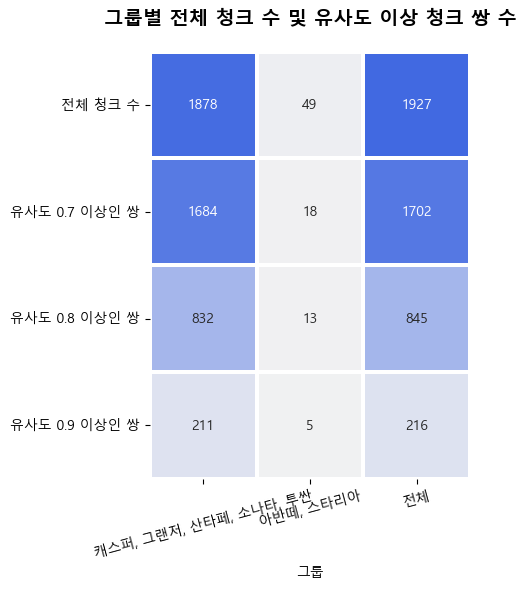

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정 (윈도우: 'Malgun Gothic', 맥: 'AppleGothic', 리눅스: 'NanumGothic')
plt.rc('font', family='Malgun Gothic')  # 너 환경에 맞게 바꿔줘
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 색상 설정
cmap = sns.light_palette("royalblue", as_cmap=True)

# 히트맵 스타일 향상
plt.figure(figsize=(9, 6))
sns.heatmap(df_transposed, annot=True, fmt='d', cmap=cmap, linewidths=1.5, linecolor='white', cbar=False, square=True)

plt.title('그룹별 전체 청크 수 및 유사도 이상 청크 쌍 수', fontsize=14, weight='bold', pad=20)
plt.yticks(rotation=0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## 생각보다 차종별 PDF 내용이 다르지 않고, 겹치는게 많다는 것을 알게 되었다.



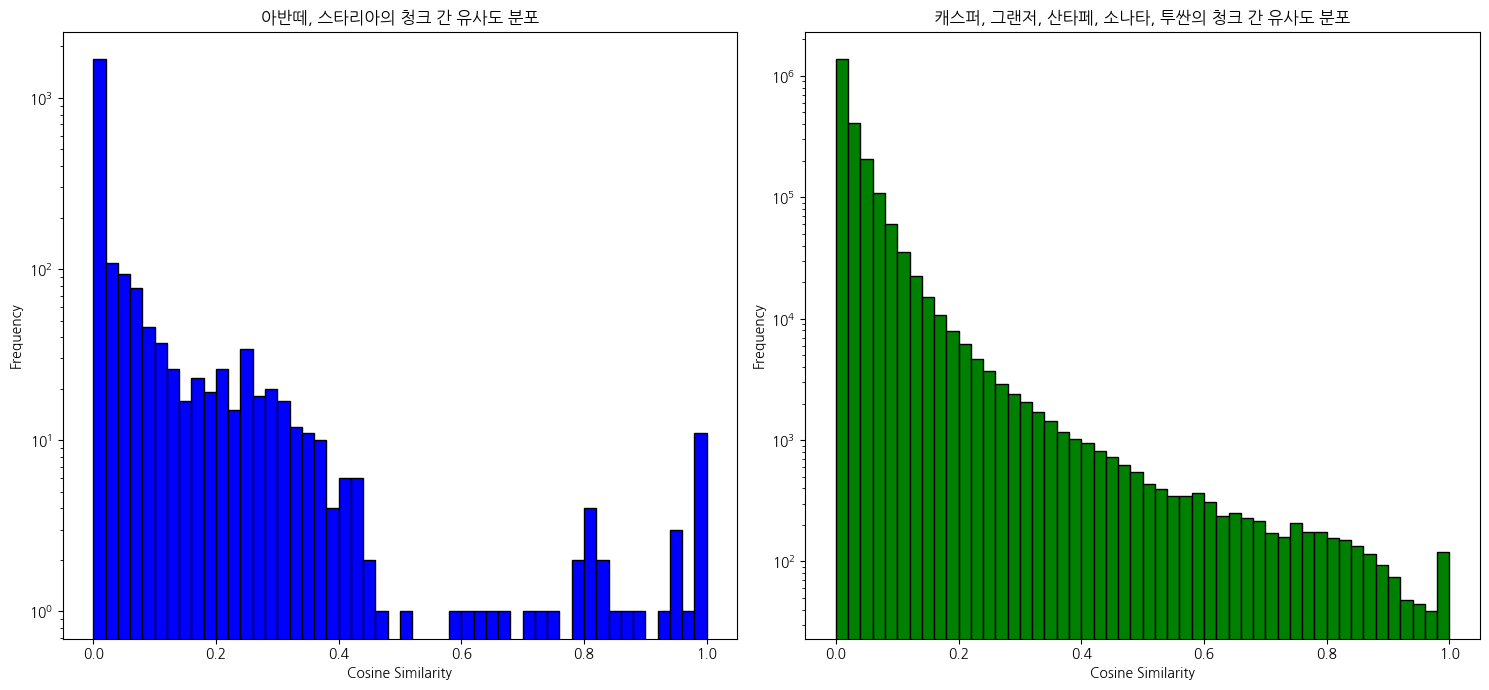

In [5]:
# 1. 유사도 값 추출
# 첫 번째 차종 그룹의 유사도 값
cos_sim_values_1 = []
for i in range(len(all_texts)):
    for j in range(i + 1, len(all_texts)):
        if car_labels[i] != car_labels[j]:
            score = cos_sim[i][j]
            cos_sim_values_1.append(score)

# 두 번째 차종 그룹의 유사도 값
cos_sim_values_2 = []
for i in range(len(all_texts2)):
    for j in range(i + 1, len(all_texts2)):
        if car_labels2[i] != car_labels2[j]:
            score = cos_sim2[i][j]
            cos_sim_values_2.append(score)

# 2. 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 첫 번째 차종 그룹의 히스토그램
axes[0].hist(cos_sim_values_1, bins=50, color='blue', edgecolor='black')
axes[0].set_title("아반떼, 스타리아의 청크 간 유사도 분포")
axes[0].set_xlabel("Cosine Similarity")
axes[0].set_ylabel("Frequency")
axes[0].set_yscale('log')  # y축 로그 스케일로 설정

# 두 번째 차종 그룹의 히스토그램
axes[1].hist(cos_sim_values_2, bins=50, color='green', edgecolor='black')
axes[1].set_title("캐스퍼, 그랜저, 산타페, 소나타, 투싼의 청크 간 유사도 분포")
axes[1].set_xlabel("Cosine Similarity")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale('log')  # y축 로그 스케일로 설정

# 레이아웃 정리
plt.tight_layout()
plt.show()


유사도 히스토그램 
오른쪽으로 긴 꼬리형태를 보인다. 즉 대부분의 청크들은 유사도가 낮지만, 유사도가 높은 청크 집합이 어느정도 존재한다고 해석
* 비교적 값이 적은 0.8이상을 효과적으로 시각화 하기 위해 y축을 로그 스케일 지정

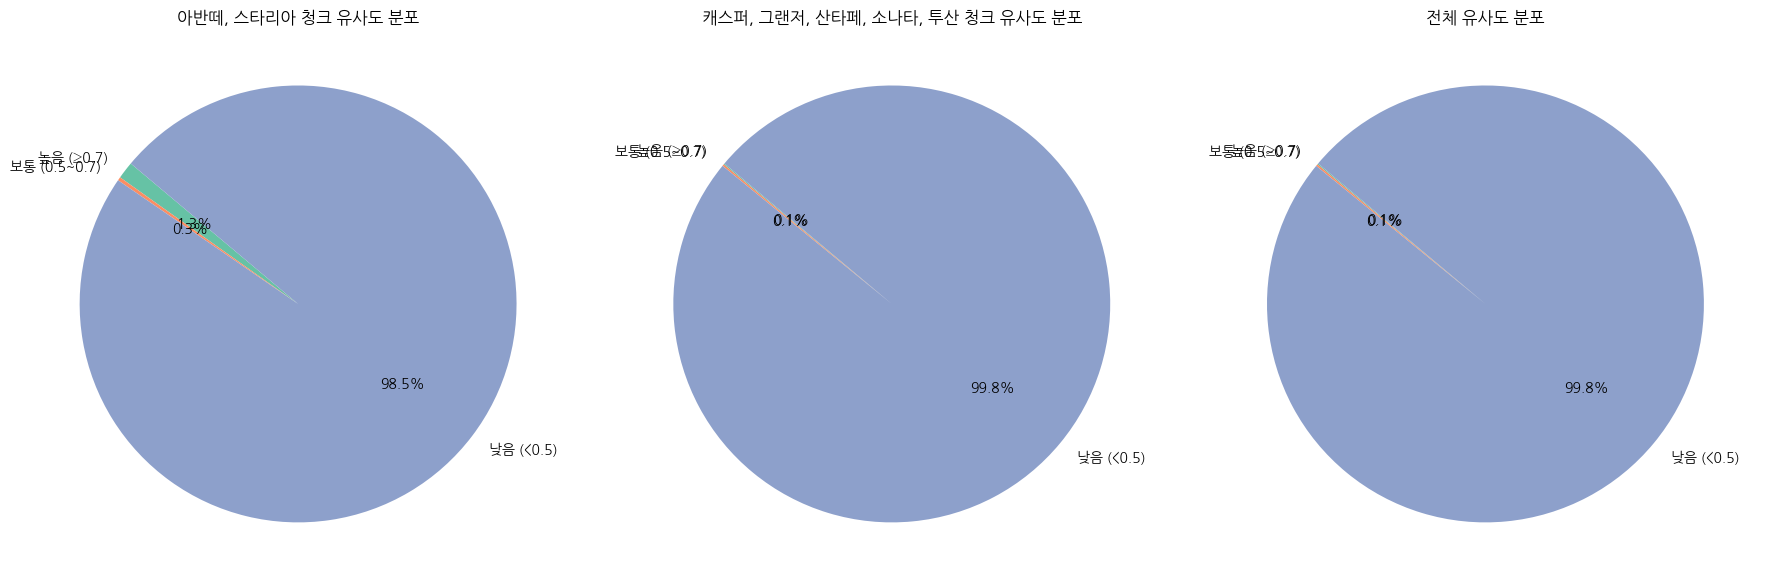

In [30]:
import matplotlib.pyplot as plt

def get_similarity_counts(cos_sim_values):
    high = sum(1 for v in cos_sim_values if v >= 0.7)
    medium = sum(1 for v in cos_sim_values if 0.5 <= v < 0.7)
    low = sum(1 for v in cos_sim_values if v < 0.5)
    return [high, medium, low]

def plot_three_pies(sim1, sim2):
    counts1 = get_similarity_counts(sim1)
    counts2 = get_similarity_counts(sim2)
    counts_total = [c1 + c2 for c1, c2 in zip(counts1, counts2)]

    labels = ['높음 (≥0.7)', '보통 (0.5~0.7)', '낮음 (<0.5)']
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].pie(counts1, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    axs[0].set_title('아반떼, 스타리아 청크 유사도 분포')

    axs[1].pie(counts2, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    axs[1].set_title('캐스퍼, 그랜저, 산타페, 소나타, 투산 청크 유사도 분포')

    axs[2].pie(counts_total, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    axs[2].set_title('전체 유사도 분포')

    plt.tight_layout()
    plt.show()

# 실행
plot_three_pies(cos_sim_values_1, cos_sim_values_2)


In [29]:
import pandas as pd

def plot_similarity_cross_table(sim1, sim2):
    counts1 = get_similarity_counts(sim1)
    counts2 = get_similarity_counts(sim2)
    counts_total = [c1 + c2 for c1, c2 in zip(counts1, counts2)]

    labels = ['높음 (≥0.7)', '보통 (0.5~0.7)', '낮음 (<0.5)']

    # 교차표 생성 (데이터프레임으로 변환)
    data = {
        '아반떼, 스타리아 청크 간 유사도': counts1,
        '캐스퍼, 그랜저, 산타페, 소나타, 투산 청크 간 유사도': counts2,
        '전체': counts_total
    }

    df = pd.DataFrame(data, index=labels)
    
    # 교차표만 출력
    print("청크 간 유사도 파악:")
    return df

# 실행
plot_similarity_cross_table(cos_sim_values_1, cos_sim_values_2)


청크 간 유사도 파악:


,"아반떼, 스타리아 청크 간 유사도","캐스퍼, 그랜저, 산타페, 소나타, 투산 청크 간 유사도",전체
높음 (≥0.7),30,1861,1891
보통 (0.5~0.7),6,3127,3133
낮음 (<0.5),2314,2287019,2289333


차종별 청크 수, 청크 당 단어 수, 청크 별 문장 수

In [35]:
import pandas as pd

# 분석 결과 저장 리스트
length_summary = []

for car in cars:
    df = globals()[car]  # 차종별 데이터프레임
    chunk_texts = df['text'].tolist()
    
    num_chunks = len(chunk_texts)
    total_words = sum(len(text.split()) for text in chunk_texts)
    avg_words_per_chunk = total_words / num_chunks
    
    # 문장 수 기준으로도 비교 가능 (옵션)
    total_sentences = sum(text.count('.') + text.count('!') + text.count('?') for text in chunk_texts)
    avg_sentences_per_chunk = total_sentences / num_chunks
    
    length_summary.append({
        'car': car,
        'num_chunks': num_chunks,
        'avg_words_per_chunk': round(avg_words_per_chunk, 2),
        'avg_sentences_per_chunk': round(avg_sentences_per_chunk, 2)
    })

# 결과 데이터프레임
length_df = pd.DataFrame(length_summary)
display(length_df.sort_values(by='avg_words_per_chunk', ascending=False))



,car,num_chunks,avg_words_per_chunk,avg_sentences_per_chunk
6,staria,50,2426.10,573.10
0,avante,47,2159.94,467.51
3,ionic5,119,877.36,218.18
1,casper,274,295.96,205.58
7,tucson,485,247.63,142.99
5,sonata,479,237.83,139.19
2,grandeur,562,197.03,125.27
4,santafe,611,182.57,110.35


아반떼와 스타리아는 다른 차종과 다르게 청크단위가 길게 저장

군집화

각 차종별 tf-idf의 점수를 이용해, DBScan방식을 이용한 군집화

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

cars = ['avante', 'casper', 'grandeur', 'ionic5', 'santafe', 'sonata', 'staria', 'tucson']

# 1. 각 차종별 상위 50개 단어의 TF-IDF 점수 기반 벡터 생성
tfidf_matrix = []
all_top_words = []  # 상위 50개 단어들을 모은 리스트

# 상위 50개 단어들을 모은 후, 각 차종의 TF-IDF 점수 벡터를 만듬
for car in cars:
    top_50 = globals()[f"{car}_top_50"]  # 각 차종별 상위 50개 단어
    top_50_words = [word for word, _ in top_50]
    all_top_words.extend(top_50_words)  # 상위 50개 단어들을 하나로 합침
    
    word_scores = globals()[f"{car}_word_scores"]  # TF-IDF 점수 가져오기
    vector = [word_scores.get(word, 0) for word in top_50_words]  # 상위 50개 단어에 대해 TF-IDF 점수
    
    tfidf_matrix.append(vector)

# all_top_words에서 중복 제거 후 정렬
all_top_words = sorted(set(all_top_words))

# 각 차종별 상위 50개 단어에 대해 TF-IDF 점수를 기반으로 한 행렬 생성
tfidf_matrix = np.array(tfidf_matrix)

# 2. DBSCAN 군집화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_matrix)

dbscan = DBSCAN(eps=1.2, min_samples=2)
labels = dbscan.fit_predict(X_scaled)

# 4. 군집화된 결과 출력
clustered_cars = {}
for idx, label in enumerate(labels):
    clustered_cars.setdefault(label, []).append(cars[idx])

print("DBSCAN 군집화 결과:")
for cluster, cluster_cars in clustered_cars.items():
    if cluster == -1:
        print(f"이상치 (noise): {cluster_cars}")
    else:
        print(f"군집 {cluster + 1}: {cluster_cars}")


DBSCAN 군집화 결과:
군집 1: ['avante', 'staria']
이상치 (noise): ['casper', 'ionic5']
군집 2: ['grandeur', 'santafe']
군집 3: ['sonata', 'tucson']


noise로 나타난 casper와 ionic5는 근방에 다른 차종이 없다고 판단되어 이상치로 판별

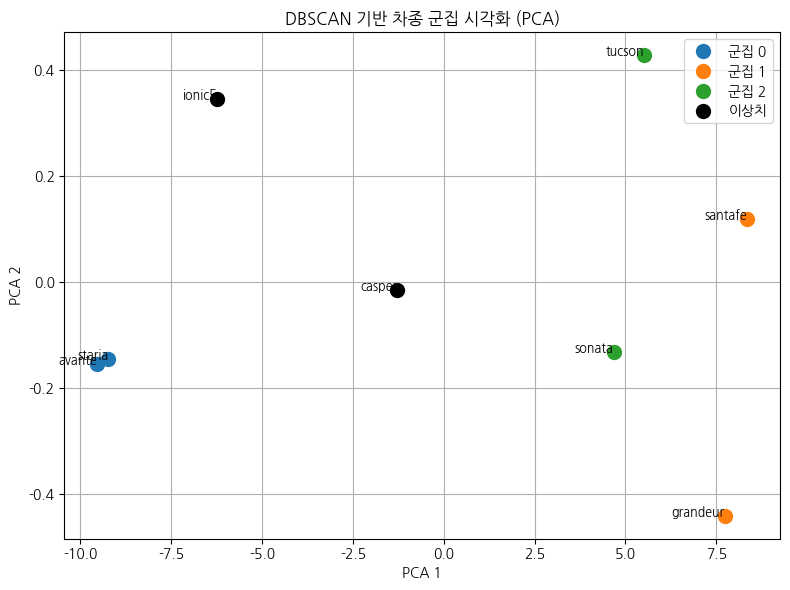

In [52]:
from sklearn.decomposition import PCA

# 3. PCA로 차원 축소
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

# 4. 시각화
plt.figure(figsize=(8, 6))
unique_labels = set(labels)

for label in unique_labels:
    indices = labels == label
    cluster_color = 'black' if label == -1 else f"C{label}"
    label_name = '이상치' if label == -1 else f"군집 {label}"
    plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1],
                label=label_name, c=cluster_color, s=100)

# 각 점에 차종 이름 표시
for i, car in enumerate(cars):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], car, fontsize=9, ha='right')

plt.title("DBSCAN 기반 차종 군집 시각화 (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3차원의 DBScan 결과를 주성분 분석을 통해 2차원으로 나타내서 시각화한 결과

avante와 straia의 tf-idf 기반 단어가 매우 유사한 것을 확인할 수 있음
다른 차종은 그렇게 유사하다고 볼 수는 없다.